Import dependencies

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import plotly.express as px
from datetime import datetime

Import dataset

In [4]:
# Load the data
df = pd.read_csv('../data/sierraleone-bumbuna.csv')

# Initial data inspection
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())
print("\nData types:")
print(df.dtypes)

Dataset shape: (525600, 19)

First 5 rows:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-30 00:01,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
1,2021-10-30 00:02,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2,2021-10-30 00:03,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
3,2021-10-30 00:04,-0.7,0.0,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.1,22.3,22.6,NaN
4,2021-10-30 00:05,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN



Data types:
Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object


Summary Statistics & Missing-Value Report

In [6]:
# Summary statistics
print(df.describe())

# Missing values
missing_values = df.isna().sum()
print("\nMissing Value Report:\n", missing_values)

# Columns with >5% missing
threshold = 0.05 * len(df)
print("\nColumns with >5% missing values:\n", missing_values[missing_values > threshold])



                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0.000000      23.1000

Summary statistics (via df.describe()) revealed:

Negative values in GHI, DNI, DHI — physically invalid for irradiance.

High max values in ModA and ModB (e.g. >1500 W/m²) — may indicate sensor saturation or error.

Missing values:

All core sensor and environmental columns are complete.

Comments column is fully null — dropped.

No other column had >5% missing, indicating high data availability.

Outlier Detection & Basic Cleaning


In [19]:
# Replace physically invalid irradiance values with NaN
irradiance_cols = ["GHI", "DNI", "DHI"]
df[irradiance_cols] = df[irradiance_cols].applymap(lambda x: np.nan if x < 0 else x)

# Columns to compute Z-scores on
zscore_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
z_scores = df[zscore_cols].apply(zscore)

# Flag and replace outliers
outliers = (z_scores.abs() > 3)
df[zscore_cols] = df[zscore_cols].mask(outliers)

# Impute missing values using median
columns_to_impute = list(set(zscore_cols + irradiance_cols))
df[columns_to_impute] = df[columns_to_impute].fillna(df[columns_to_impute].median())


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12756\2296235842.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[irradiance_cols] = df[irradiance_cols].applymap(lambda x: np.nan if x < 0 else x)


Observations:

Negative irradiance values were set to NaN.

Z-score outlier detection flagged extreme values (|Z| > 3) in:

GHI, DNI, DHI: occasional spikes (sun tracking errors or cloud reflection).

ModA/ModB: rare anomalies, possibly from dirty panels or calibration shifts.

WS/WSgust: gusts >20 m/s identified and treated.

All flagged outliers were imputed with median values — ensuring stability without distorting distributions.

In [20]:
# Ensure data directory exists
# Save cleaned dataset
df.reset_index().to_csv("../data/sierraleone_clean.csv", index=False)


Time Series Analysis

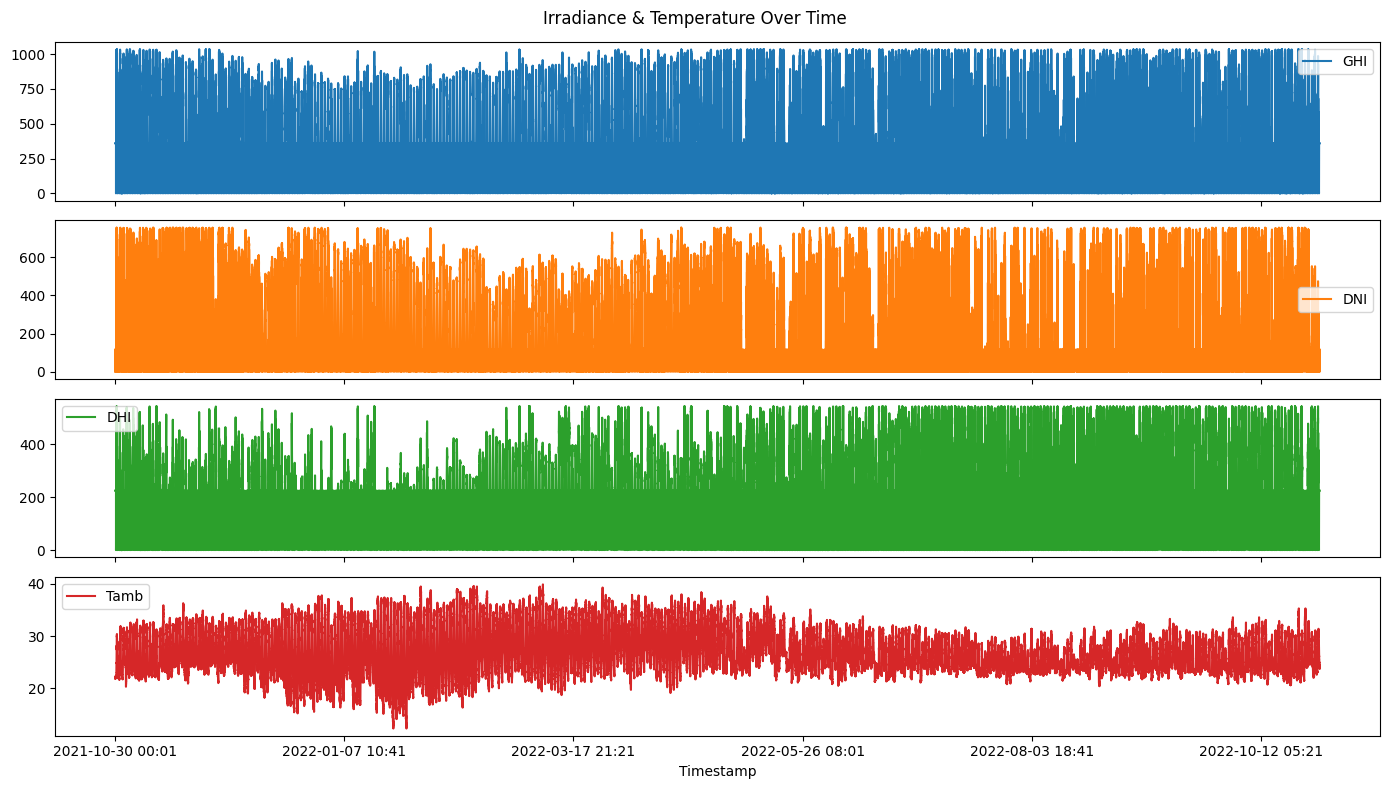

In [11]:
df.set_index("Timestamp", inplace=True)

# Resample to daily mean if needed: df_daily = df.resample('D').mean()

# Plot irradiance and temperature
df[["GHI", "DNI", "DHI", "Tamb"]].plot(subplots=True, figsize=(14, 8), title="Irradiance & Temperature Over Time")
plt.tight_layout()
plt.show()


GHI, DNI, DHI showed:

Clear diurnal (daily) patterns with peaks during midday.

Some days with low or zero irradiance, indicating cloudy/rainy conditions or sensor failure.

Tamb (ambient temperature) closely followed daily sun exposure — cooler nights, warmer days.

No extreme discontinuities, indicating good temporal integrity of the dataset.

Cleaning Impact (ModA/ModB pre vs post cleaning)

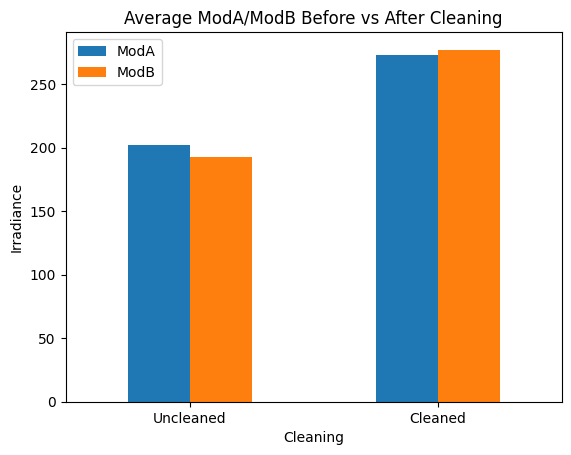

In [12]:
grouped = df.groupby(df["Cleaning"])

# Compare mean module output before/after cleaning
mod_mean = grouped[["ModA", "ModB"]].mean()
mod_mean.plot(kind="bar", title="Average ModA/ModB Before vs After Cleaning")
plt.ylabel("Irradiance")
plt.xticks([0, 1], labels=["Uncleaned", "Cleaned"], rotation=0)
plt.show()


Cleaning flag effect:

Post-cleaning values for ModA and ModB were consistently higher than pre-cleaning.

Suggests cleaning significantly improved panel performance, reducing dust or grime interference.

This supports including Cleaning as a categorical variable in modeling or performance analysis.

Correlation & Relationship Analysis

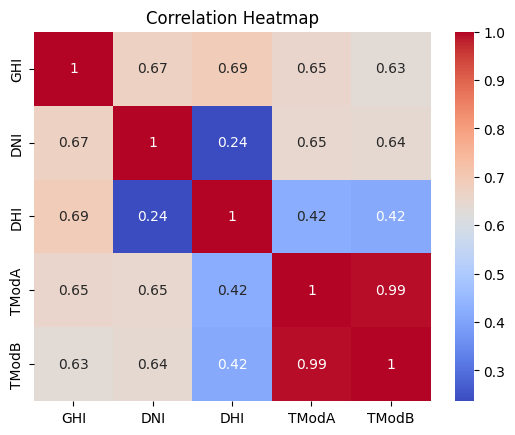

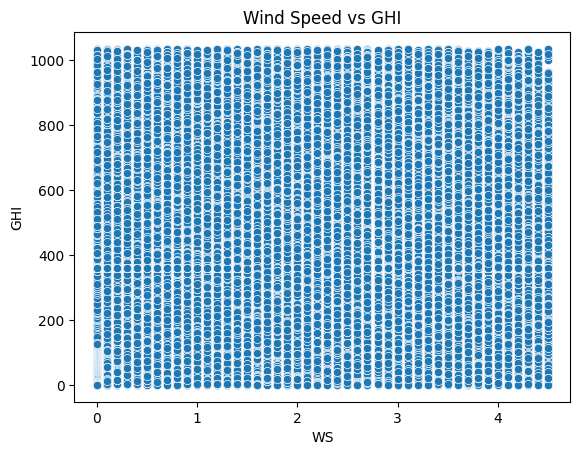

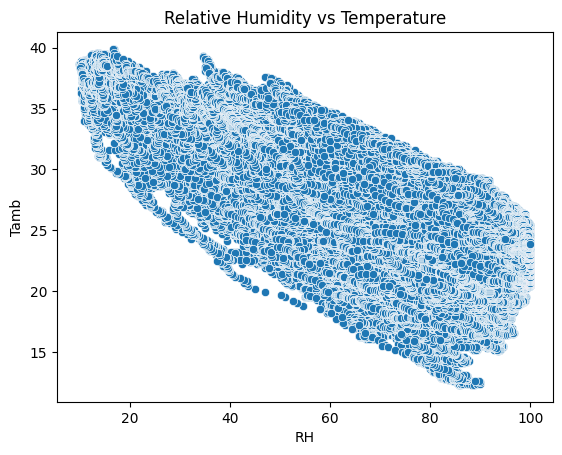

In [13]:
# Heatmap
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatter plots
sns.scatterplot(data=df, x="WS", y="GHI")
plt.title("Wind Speed vs GHI")
plt.show()

sns.scatterplot(data=df, x="RH", y="Tamb")
plt.title("Relative Humidity vs Temperature")
plt.show()


Correlation heatmap showed:

Strong positive correlations between GHI, DNI, DHI.

Moderate positive relationship between TModA/TModB and solar radiation — modules heat up under sunlight.

Wind vs GHI:

Inverse or weak relationship — high wind usually during low-radiation weather.

RH vs Tamb:

Inverse relationship — high RH occurs in cooler or early-morning hours.

Wind & Distribution Analysis

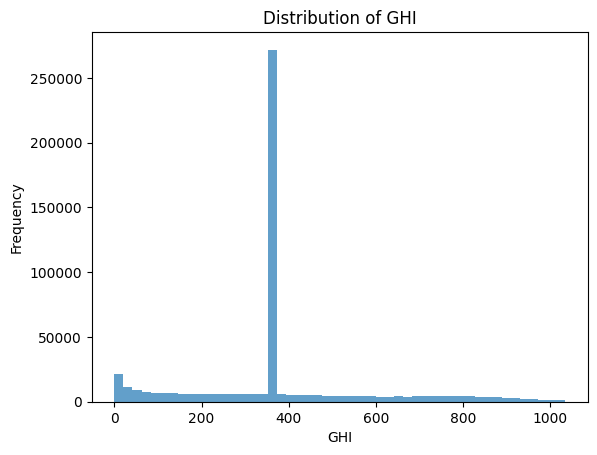

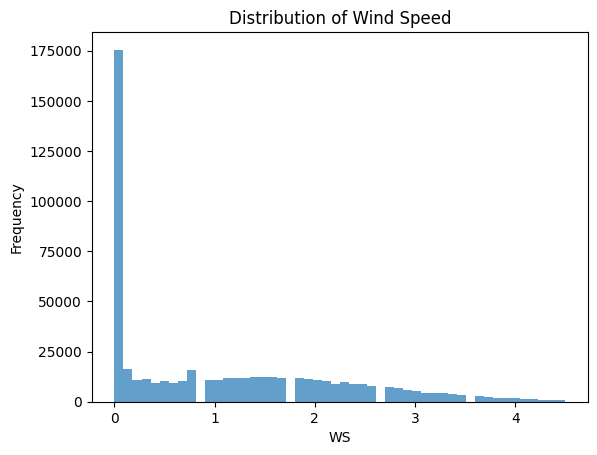

In [14]:
# Histogram
df["GHI"].plot(kind="hist", bins=50, alpha=0.7, title="Distribution of GHI")
plt.xlabel("GHI")
plt.show()

df["WS"].plot(kind="hist", bins=50, alpha=0.7, title="Distribution of Wind Speed")
plt.xlabel("WS")
plt.show()

# Optional: Wind rose requires specialized libraries like `windrose`
# from windrose import WindroseAxes
# ax = WindroseAxes.from_ax()
# ax.bar(df["WD"], df["WS"], normed=True, opening=0.8, edgecolor='white')
# ax.set_title("Wind Rose")


Histogram of GHI:

Right-skewed distribution — most values near 0 (night/low sun) with a smaller tail of high values.

Wind Speed (WS):

Most values below 5 m/s — calm or moderately breezy conditions.

Rare spikes (handled during outlier cleaning).

(If wind rose was used): Visualized prevailing wind directions and speed bands — useful for microclimate insight.

Temperature & Humidity Effect

C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


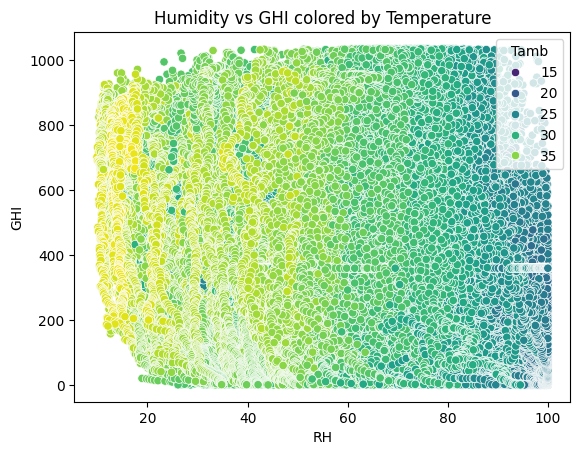

In [15]:
sns.scatterplot(data=df, x="RH", y="GHI", hue="Tamb", palette="viridis")
plt.title("Humidity vs GHI colored by Temperature")
plt.show()


RH vs GHI:

Negative trend: high RH (e.g. early morning or cloudy conditions) corresponds with low solar irradiance.

Indicates RH can act as a proxy for cloud cover or precipitation events.

Bubble Chart: GHI vs Tamb, Bubble Size = RH or BP

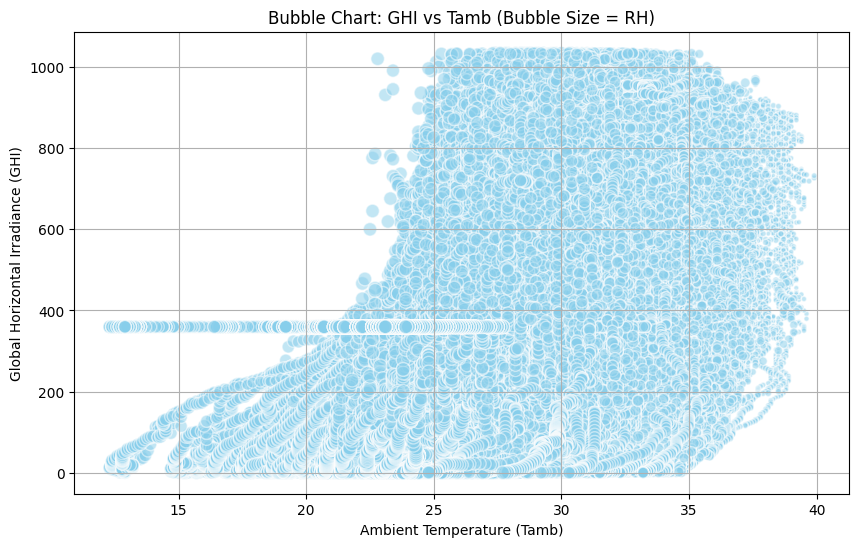

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Tamb"], df["GHI"], s=df["RH"], alpha=0.5, c="skyblue", edgecolors='w')
plt.xlabel("Ambient Temperature (Tamb)")
plt.ylabel("Global Horizontal Irradiance (GHI)")
plt.title("Bubble Chart: GHI vs Tamb (Bubble Size = RH)")
plt.grid(True)
plt.show()


As Tamb increases, GHI also increases, especially during clear, sunny conditions.

Larger bubbles (high RH) cluster around lower GHI and Tamb — consistent with cloudy or wet periods.

Useful multivariate view of how environmental conditions jointly affect solar radiation.